First we create a timeseries with two curves between 0 and 10 seconds. The time samples are randomly varied (sample time is not constant). This could be for example results of simulations with an adaptive (variable) step solver.  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Axes: xlabel='time'>

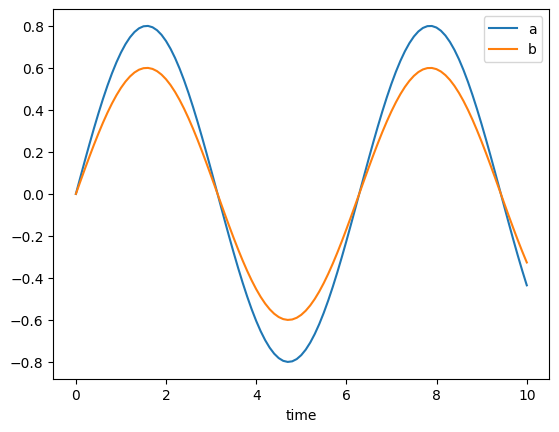

In [72]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append(r"..\src")

import trimes
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

t_start = 0
t_end = 10
average_time_step = 0.1
number_of_steps = int(np.round(t_end / average_time_step))
time_steps = (
    average_time_step - (np.random.rand(number_of_steps) * 0.001) * average_time_step
)
time = np.cumsum(time_steps)
time = np.concatenate(
    ([t_start], time, [np.ceil(time[-1])])
)  # Make sure that the first time step is zero and the last equals to 10. This is not a generic requirement of trimes, but necessary for this tutorial.
val_a = np.sin(time) - np.sin(time)*0.2
val_b = (np.sin(time) - np.sin(time)*0.4)

df_ts = pd.DataFrame({"a": val_a, "b": val_b}, index=time)
df_ts.index.name = "time"
df_ts.plot()

Next we create a reference signal with a different sampling time compare to above. 

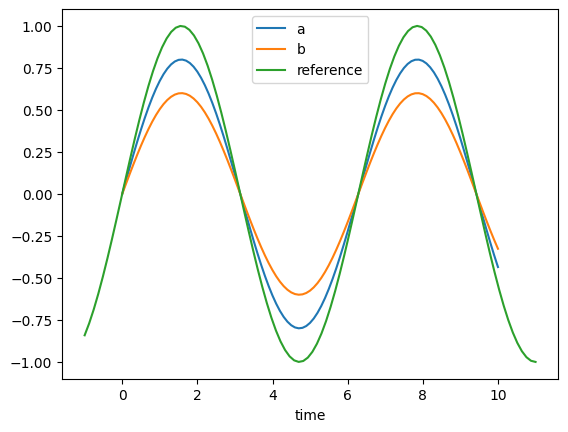

In [73]:
time = np.linspace(t_start - 1, t_end + 1, 100)
reference = np.sin(time)
series_reference = pd.Series(reference, index=time, name="reference")
series_reference.index.name = "time"
df_ts.plot()
series_reference.plot()

plt.legend(loc="upper center")

We calculate the difference between signals 'a'/'b' and the reference. To illustrate a plot with two y-axes is used (original signals on the left axis, difference on the right). In addition, the area between 'b' and 'reference' is filled.

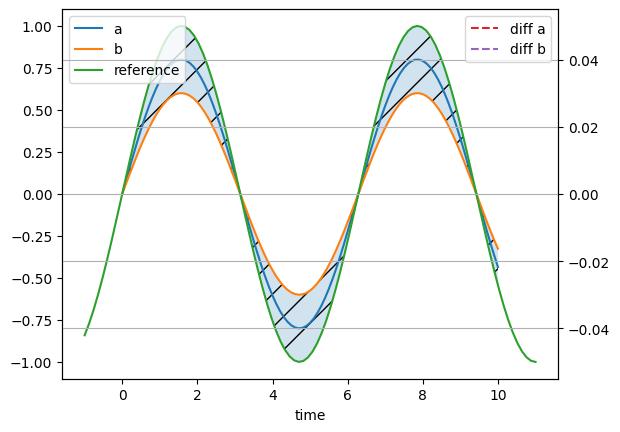

In [74]:
from trimes.comparison import subtract
from trimes.plots import plot_2y, fill_between

diff = subtract(df_ts, series_reference)
diff.columns = ("diff a", "diff b")
ax1, ax2 = plot_2y(
    pd.concat([df_ts, series_reference]), diff, kwargs_ax2={"linestyle": "--"}
)
fill_between(ax1, df_ts["b"], series_reference, alpha=0.2, hatch="/")
plt.grid()

# Boundaries and Envelopes

## Create Time Series Signals

<Axes: >

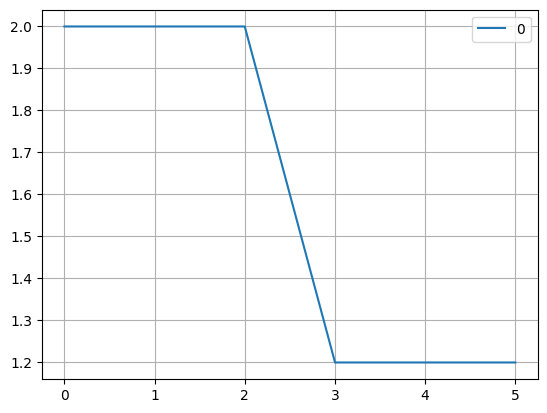

In [75]:
from trimes.signal_generation import linear_time_series

t = (0, 2, 3, 3, 5)
y = (2, 2, 1.5, 1.2, 1.2)
sample_time = 1e-3

ts = linear_time_series(t, y, sample_time)
ts.plot(grid=True)

<Axes: >

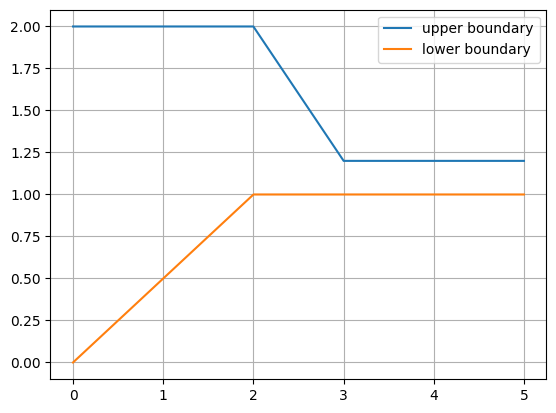

In [76]:
y = [(2, 2, 1.5, 1.2, 1.2), (0, 1, 1, 1, 1)]

ts = linear_time_series(t, y, sample_time)
ts.columns = ("upper boundary", "lower boundary")
ts.plot(grid=True)

<Axes: >

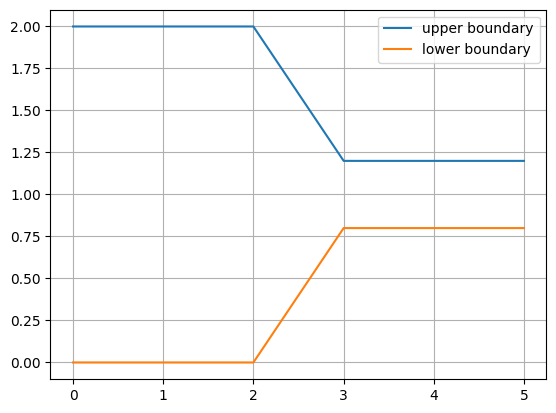

In [77]:
from trimes.signal_generation import mirror_y

ts_envelope = mirror_y(ts.iloc[:, 0], 1, inplace=True)
ts_envelope.columns = ("upper boundary", "lower boundary")
ts_envelope.plot(grid=True)

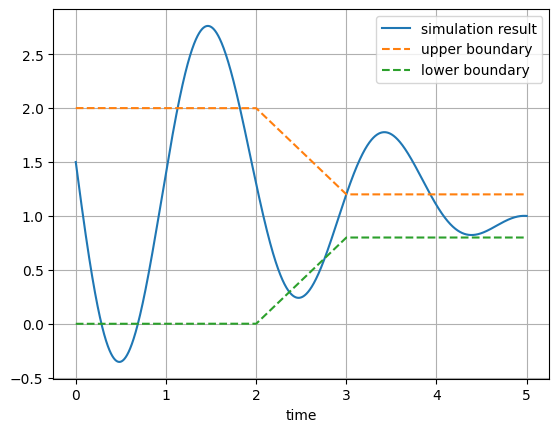

In [78]:
from trimes.signal_generation import PeriodicSignal
from trimes.plots import fill_between

signal = PeriodicSignal(
    np.arange(0, 5 + sample_time, sample_time),
    f=0.5,
    offset=(1.5, 1),
    mag=(2, 0.01),
    phi=np.pi / 2,
)
wave = signal.get_signal_series()
wave.name = "simulation result"
ax = plt.subplot()
wave.plot(ax=ax)
ts_envelope.plot(ax=ax, linestyle="--")
plt.legend()
plt.grid()

## Check Boundaries

In [79]:
import operator
from trimes.comparison import apply_operator_df, apply_operator_series

greater_df = apply_operator_df(ts_envelope, wave, operator.lt)

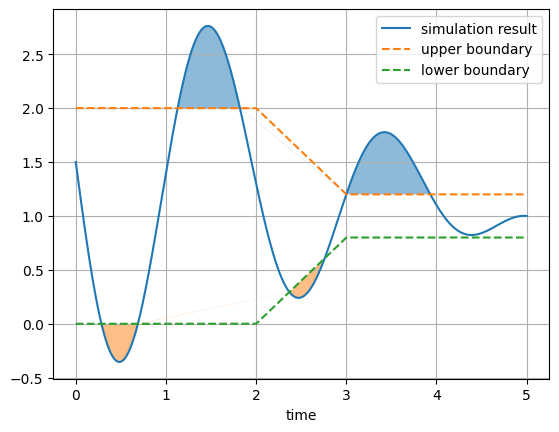

In [80]:
greater = apply_operator_series(wave, ts_envelope.iloc[:, 0], operator.gt)
smaller = wave.to_numpy() < ts_envelope.iloc[:, 1].to_numpy()

outside = np.logical_or(greater, smaller)

ax = plt.subplot()
wave.plot(ax=ax)
ts_envelope.plot(ax=ax, linestyle="--")
fill_between(ax, wave.iloc[greater], ts_envelope.iloc[greater, 0], alpha=0.5)
fill_between(ax, wave.iloc[smaller], ts_envelope.iloc[smaller, 1], alpha=0.5)
plt.legend()
plt.grid()

In [81]:
from trimes.comparison import comparison_series, comparison_df
from trimes.metrics import integral_squared_error, integral_abs_error

print(
    comparison_series(
        wave, ts_envelope.iloc[:, 0], operator.gt, metric=integral_abs_error
    )
)
print(
    comparison_series(
        wave, ts_envelope.iloc[:, 1], operator.lt, metric=integral_abs_error
    )
)
print(
    comparison_df(
        pd.concat([wave, wave * 1.1], axis=1),
        ts_envelope.iloc[:, 0],
        operator.gt,
        metric=integral_abs_error,
    )
)

0.6832649919854159
0.138029007650943
[0.68326499 1.01708433]


In [82]:
from trimes.comparison import envelope_comparison_series

envelope_comparison_series(wave, ts_envelope)

np.float64(0.8212939996363589)

In [83]:
from trimes.comparison import envelope_comparison_df

envelope_comparison_df(pd.concat([wave, wave], axis=1), ts_envelope)

array([0.821294, 0.821294])

## Step Info

<Axes: xlabel='time'>

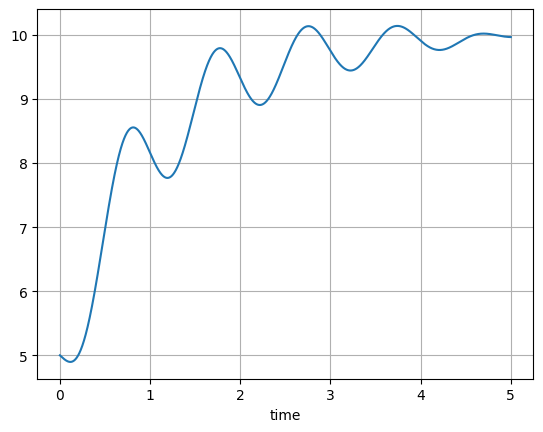

In [84]:
t = np.arange(0, 5 + sample_time, sample_time)
offset = 10 - 5 * np.exp(-t)
step_response = PeriodicSignal(
    np.arange(0, 5 + sample_time, sample_time),
    f=1,
    offset=offset,
    mag=(1, 0.01),
    phi=np.pi / 2,
)
step_series = step_response.get_signal_series()
step_series.name = "step response"
step_series.plot(grid=True)

Note that the *y* values in the results are relative to the initial value. 

In [85]:
from trimes.control import step_info_series

info = step_info_series(step_series)
info

{'RiseTime': np.float64(1.303),
 'SettlingTime': np.float64(4.405),
 'SettlingMin': np.float64(3.906303780009649),
 'SettlingMax': np.float64(5.140223553657352),
 'Overshoot': np.float64(3.501861127732394),
 'Undershoot': np.float64(2.0758071455346307),
 'Peak': np.float64(5.140223553657352),
 'PeakTime': np.float64(3.742),
 'SteadyStateValue': np.float64(4.966310265004573)}

4.896908976649615


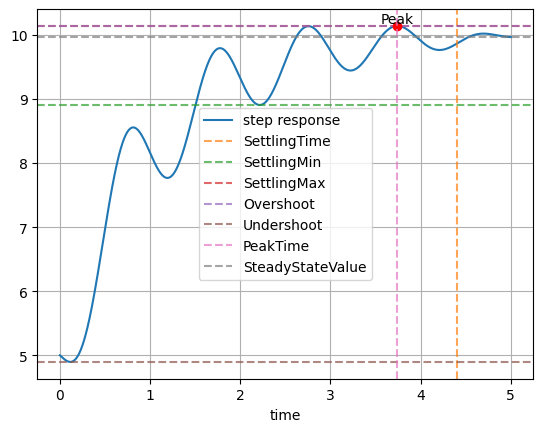

In [86]:
from trimes.control import plot_step_info

step_series.plot(grid=True)
plot_step_info(step_series, info)
plt.legend()